In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas_datareader import data as web
from pmdarima import auto_arima
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import kpss, adfuller

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
plt.rcParams['font.size'] = 10

In [4]:
plt.rcParams["legend.loc"] = "upper left"

In [5]:
df = pd.read_excel('C:/JupyterLab/AI_prediction/data/raw/EU_ml_models.xlsx')

In [6]:
df

,year,ml_models
0,2003,2
1,2004,0
2,2005,2
3,2006,6
4,2007,3
5,2008,2
6,2009,1
7,2010,4
8,2011,2
9,2012,2


In [7]:
df = df.set_index('year', drop=False)

([<matplotlib.axis.XTick at 0x1431bb5e660>,
 [Text(2004, 0, '2004'),
  Text(2007, 0, '2007'),
  Text(2010, 0, '2010'),
  Text(2013, 0, '2013'),
  Text(2016, 0, '2016'),
  Text(2019, 0, '2019'),
  Text(2022, 0, '2022')])

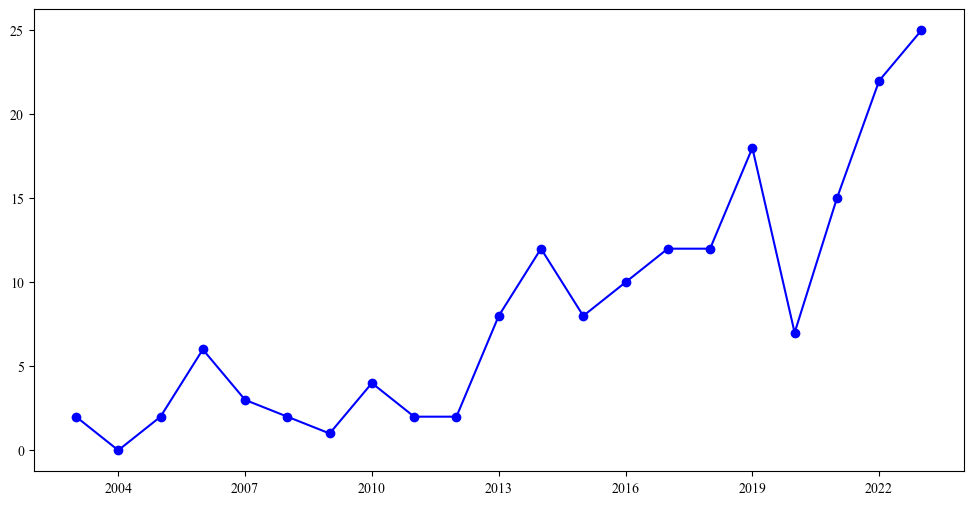

In [8]:
xticks_labels = df.index.tolist()
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

plt.figure(figsize=(12, 6))
plt.plot(df['ml_models'], marker='o', color='blue', label='ml_models')
plt.xticks(xticks_filtered)

As in other regions, the number of models fluctuated significantly during the period under review. There is an upward trend in the data, but its polynomial was determined by comparing two models estimated using the classical least squares method.

### Trend type verification

In [9]:
y = df["ml_models"]
t = df["year"]

X_lin = sm.add_constant(t)
model_lin = sm.OLS(y, X_lin).fit()

X_quad = sm.add_constant(np.column_stack((t, t**2)))
model_quad = sm.OLS(y, X_quad).fit()

# Linear model statistics
p_value_lin = model_lin.pvalues.iloc[1] 
r2_lin = model_lin.rsquared
se_lin = np.sqrt(model_lin.mse_resid)
f_lin = model_lin.fvalue
f_crit_lin = stats.f.ppf(0.95, model_lin.df_model, model_lin.df_resid)

# Quadratic model statistics
p_value_quad = model_quad.pvalues.iloc[1]
r2_quad = model_quad.rsquared
se_quad = np.sqrt(model_quad.mse_resid)
f_quad = model_quad.fvalue
f_crit_quad = stats.f.ppf(0.95, model_quad.df_model, model_quad.df_resid)

# Degrees of freedom 
n = len(df)
k_lin = X_lin.shape[1] 
k_quad = X_quad.shape[1] 

df1_new = n - k_lin - 1
df2_new = n - k_quad - 1

F_user_updated = (se_lin / se_quad) ** 2
F_crit_updated = stats.f.ppf(0.95, df1_new, df2_new)

pd.options.display.float_format = '{:.8f}'.format

results_updated = pd.DataFrame({
    "Statistic": [
        "p-value (t-test for trend coefficient)",
        "R-squared",
        "Standard error of residuals",
        "F-statistic (user definition)",
        "Critical F (alpha=0.05, user definition)"
    ],
    "Linear trend model": [
        p_value_lin, r2_lin, se_lin, F_user_updated, F_crit_updated
    ],
    "Quadratic trend model": [
        p_value_quad, r2_quad, se_quad, F_user_updated, F_crit_updated
    ]
})

results_updated

,Statistic,Linear trend model,Quadratic trend model
0,p-value (t-test for trend coefficient),0.00000061,0.01154555
1,R-squared,0.73848076,0.81873837
2,Standard error of residuals,3.75391646,3.21089619
3,F-statistic (user definition),1.36683685,1.36683685
4,"Critical F (alpha=0.05, user definition)",2.25667097,2.25667097


Based on the coefficient of determination, it was determined that the model with a quadratic trend fitted the data better than the model with a linear trend. The Akaike information criterion was also slightly lower. The obtained p values ​​indicate that the parameters for both the linear and quadratic trend are significant in the models. However, Fisher's exact test did not reveal a significant difference between the models; the critical value was significantly higher than the squared standard error of the residuals. Further calculations assumed that a quadratic trend did not occur in the data.

### Stationarity testing

In [10]:
kpss(df["ml_models"], nlags=4, regression="ct")
df["time"] = df["year"]
df["timesq"] = df["year"]**2
X_trend = sm.add_constant(df[["time", "timesq"]])
model_trend = sm.OLS(df["ml_models"], X_trend).fit()
residuals_trend = model_trend.resid
kpss(residuals_trend, regression="c", nlags=4)

C:\Users\tester\AppData\Local\Temp\ipykernel_15056\1192270414.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(residuals_trend, regression="c", nlags=4)


(np.float64(0.08740819076207253),
 np.float64(0.1),
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [11]:
def check_stationarity(series):
    # Source https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
check_stationarity(df['ml_models'])

ADF Statistic: -0.499064
p-value: 0.892199
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651
Non-stationary


In [13]:
adf_result_original = adfuller(df['ml_models'])

In [14]:
time_series_diff = np.diff(df["ml_models"])

df_diff = pd.DataFrame({"Differenced": time_series_diff})

In [15]:
def check_stationarity(series):
    # Source https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [16]:
check_stationarity(df_diff['Differenced'])

ADF Statistic: -8.840131
p-value: 0.000000
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
Stationary


In [17]:
adf_result_diff = adfuller(df_diff['Differenced'])

Time series integrated in the first degree

### Autocorelation functions

In [18]:
time_series_diff = np.diff(df["ml_models"])

df_diff = pd.DataFrame({"Differenced": time_series_diff})

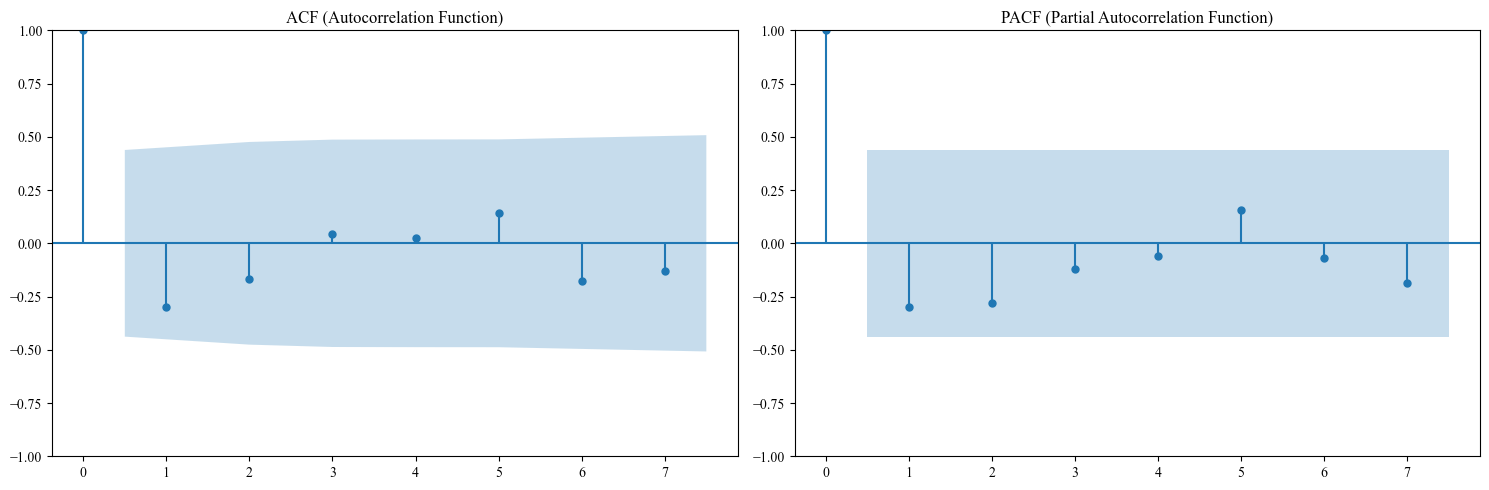

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.tsa.plot_acf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[0], title="ACF (Autocorrelation Function)")

sm.graphics.tsa.plot_pacf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[1], title="PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

The ACF function showed no strong, repeating patterns or slow decay, so differencing brought the series to a stationary form. None of the values for subsequent shifts in the plots fell outside the confidence interval. Therefore, the series most likely lacks AR and MA components.

### ARIMA forecast on training dataset

#### Chosing best ARIMA model

In [20]:
df2 = df.set_index('year')

In [21]:
train_size = len(df) - 4  
train, test = df['ml_models'][:train_size], df['ml_models'][train_size:]
train_years = df['year'][:train_size]
test_years = df['year'][train_size:]

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [23]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, d=1, start_q=0, information_criterion='aic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.562, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.102, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.994, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.247, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.135 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -41.124
Date:                Mon, 20 Oct 2025   AIC                             84.247
Time:                        12:32:25   BIC                             85.020
Sample:                             0   HQIC                            84.287
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.9999      4.468      2.238      0.025       1.244      18.756
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.50   Prob(JB):                         0.67
Heteroskedasticity (H):               1.76   Skew:                             0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, d=1, start_q=0, information_criterion='bic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=86.107, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=88.420, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=87.311, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=85.020, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.159 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -41.124
Date:                Mon, 20 Oct 2025   AIC                             84.247
Time:                        12:32:25   BIC                             85.020
Sample:                             0   HQIC                            84.287
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.9999      4.468      2.238      0.025       1.244      18.756
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.50   Prob(JB):                         0.67
Heteroskedasticity (H):               1.76   Skew:                             0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the perspective of the value of both criteria, the best model was found to be one without autoregressive (AR) or moving average (MA) components. A model fitting attempt based on the training set confirmed the conclusions drawn from the analysis of the ACF and PACF graphs. Due to the obtained results, further estimation and forecasting using the ARIMA model based on the training set was abandoned. Holt's model was used for this purpose.

### ARIMA forecast on full dataset

#### Choosing best ARIMA model

In [25]:
stepwise_fit = auto_arima(df['ml_models'], trace=True, start_p=0, d=1, start_q=0, information_criterion='aic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.464, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.613, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=117.356, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=118.822, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=119.540, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.468 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -55.678
Date:                Mon, 20 Oct 2025   AIC                            117.356
Time:                        12:32:25   BIC                            120.343
Sample:                             0   HQIC                           117.939
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0305      0.300      3.438      0.001       0.443       1.618
ma.L1         -0.6706      0.227     -2.951      0.003      -1.116      -0.225
sigma2        14.8807      5.563      2.675      0.007       3.978      25.783
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.66   Prob(JB):                         0.96
Heteroskedasticity (H):               3.68   Skew:                            -0.02
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
stepwise_fit = auto_arima(df['ml_models'], trace=True, start_p=0, d=1, start_q=0, information_criterion='bic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=121.455, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=122.600, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=120.343, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=119.817, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.145 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -58.411
Date:                Mon, 20 Oct 2025   AIC                            118.822
Time:                        12:32:26   BIC                            119.817
Sample:                             0   HQIC                           119.016
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        20.1499      6.283      3.207      0.001       7.835      32.465
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.15   Prob(JB):                         0.26
Heteroskedasticity (H):               6.43   Skew:                            -0.78
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The lowest AIC value was obtained by the model with the MA component and the intercept. In terms of the BIC criterion, the (0,1,1) model with the intercept was ranked second. Due to the selection of a model with at least one component by the criteria, an attempt was made to use the ARIMA model for the series

#### ARIMA(0,1,1) forecast

In [27]:
data = {'Date': [2024, 2025, 2026, 2027]}

future_dates = pd.DataFrame(data)

print(future_dates)

   Date
0  2024
1  2025
2  2026
3  2027


In [28]:
future_dates = [2024, 2025, 2026, 2027]

In [29]:
sarima=ARIMA(df['ml_models'],order=(0,1,1), trend='t')
predicted=sarima.fit()

In [30]:
print(predicted.summary())

                               SARIMAX Results                                
Dep. Variable:              ml_models   No. Observations:                   21
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -55.678
Date:                Mon, 20 Oct 2025   AIC                            117.356
Time:                        12:32:26   BIC                            120.343
Sample:                             0   HQIC                           117.939
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0305      0.300      3.438      0.001       0.443       1.618
ma.L1         -0.6706      0.227     -2.951      0.003      -1.116      -0.225
sigma2        14.8806      5.563      2.675      0.0

In [31]:
residuals = predicted.resid

In [32]:
forecast_steps = 4
forecast = predicted.get_forecast(steps=forecast_steps)

forecast_index = range(df2.index[-1] + 1, df2.index[-1] + 1 + forecast_steps)

forecast_values = forecast.predicted_mean

confidence_intervals = forecast.conf_int(alpha=0.25)
lower_bounds = confidence_intervals.iloc[:, 0] 
upper_bounds = confidence_intervals.iloc[:, 1]

df_forecast = pd.DataFrame({
    'Prediction': forecast_values.values,  
    'Lower Bound': lower_bounds.values,
    'Upper Bound': upper_bounds.values
}, index=forecast_index)

print(df_forecast)

      Prediction  Lower Bound  Upper Bound
2024 21.72862208  17.29110042  26.16614375
2025 22.75913617  18.08702990  27.43124244
2026 23.78965026  18.89418752  28.68511300
2027 24.82016435  19.71110045  29.92922825


In [33]:
forecast_index

range(2024, 2028)

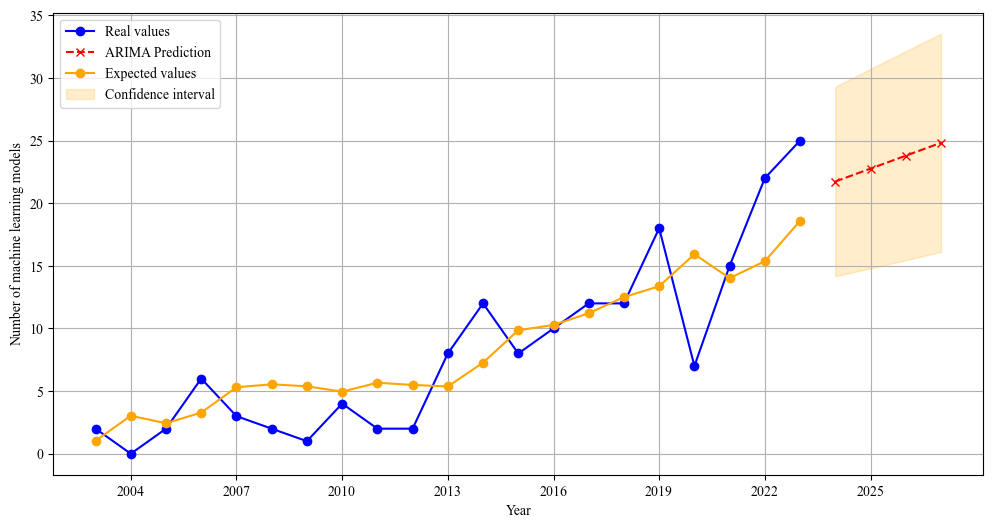

In [34]:
xticks_labels = df2.index.tolist()
xticks_labels.extend(future_dates)
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

predicted=sarima.fit().predict();predicted

conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df2['ml_models'], marker='o', color='blue', label='Real values')
plt.plot(forecast_index, forecast.predicted_mean, marker='x', linestyle='--', color='red', label='ARIMA Prediction')
plt.plot(df2.index, predicted, marker='o', color='orange', label='Expected values')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence interval')

plt.xlabel("Year")
plt.ylabel('Number of machine learning models')
plt.xticks(xticks_filtered)
plt.legend()
plt.grid(True)
plt.show()

The expected values were significantly smoother than the actual data. There was a significant increase in values between 2020 and 2023 that was not captured by the model, so the forecast is very pessimistic.

In [35]:
mse_ar = mean_squared_error(df2['ml_models'], predicted)
rmse_ar = np.sqrt(mse_ar)
mae_ar = mean_absolute_error(df2['ml_models'], predicted)
rsquare_ar = r2_score(df2['ml_models'], predicted)
mape_ar = np.mean(np.abs((df2['ml_models'] - predicted)) / df2['ml_models'])* 100

print(f"Mean Squared Error (MSE): {mse_ar}")
print(f"RMSE: {rmse_ar:.2f}")
print(f"Mean Absolute Error (MAE): {mae_ar}")
print(f'Determination:', rsquare_ar)
print(f"Mean Absolute Percentage Error (MAPE): {mape_ar}")

Mean Squared Error (MSE): 14.389028138417808
RMSE: 3.79
Mean Absolute Error (MAE): 3.0408443567911445
Determination: 0.7048576088817556
Mean Absolute Percentage Error (MAPE): inf


In [36]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Test Shapiro–Wilka: statystyka = 0.9701, p-value = 0.7353


In [37]:
arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.3997


Based on the p-values, the null hypotheses of the tests were rejected. The model residuals are normally distributed and do not exhibit variable variance. The model residuals are normally distributed and do not exhibit variable variance.

### Regular and dumped Holt model forecast on training dataset

To balance and compare more models matching the data, a dumped Holt model, which suppresses exponential growth that may disturb the prediction, was estimated.

In [38]:
# Regular Holt model
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(4)

# Dumped Holt model
holt_damped_model = ExponentialSmoothing(train, trend='add', damped_trend=True, seasonal=None).fit()
holt_damped_forecast = holt_damped_model.forecast(4)

In [39]:
future_years = test_years.values

(0.0, 30.0)

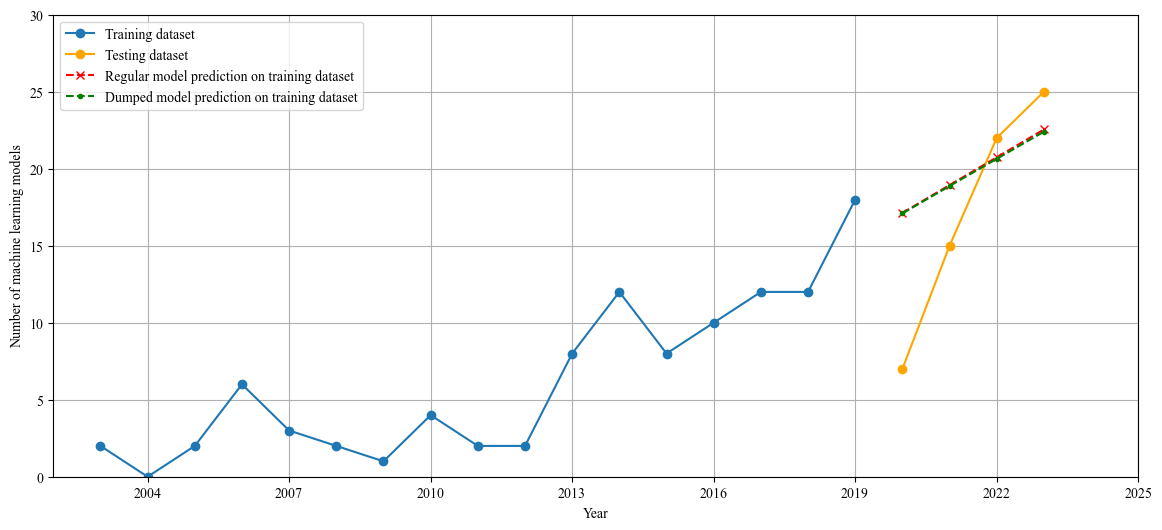

In [40]:
plt.figure(figsize=(14, 6))

plt.plot(train_years, train, label='Training dataset', marker='o')
plt.plot(test_years, test, label='Testing dataset', color='orange', marker='o')
plt.plot(future_years, holt_forecast, label='Regular model prediction on training dataset', marker='x', linestyle='--', color='red')
plt.plot(future_years, holt_damped_forecast,label='Dumped model prediction on training dataset',marker='.', linestyle='--', color='green')

plt.xlabel("Year")
plt.ylabel("Number of machine learning models")
plt.legend()
plt.xticks(xticks_filtered)
plt.grid(True)
plt.ylim(0, 30)

In [41]:
print("Damping parameter (phi):", holt_damped_model.params['damping_trend'])

Damping parameter (phi): 0.994999999814659


In [42]:
holt_damped_forecast

17   17.09922295
18   18.87603487
19   20.64396273
20   22.40305095
dtype: float64

In [43]:
holt_forecast

17   17.13083360
18   18.93681614
19   20.74279868
20   22.54878122
dtype: float64

Forecasts made with the dumping model were very similar to those of Holt's models without modification. This was due to the slow and linear rise of the values in the training set and the short time series. Unsuprisingly, the predictions of both models differ significantly from the values recorded in 2020. Therefore, they can be treated as a counterfactual scenario – indicating what the development trajectory might have looked like had it not been for the outbreak of the pandemic.

In [44]:
mse_u = mean_squared_error(test, holt_forecast)
rmse_u = np.sqrt(mean_squared_error(test, holt_forecast))
mae_u = mean_absolute_error(test, holt_forecast)
mape_u = np.mean(np.abs((test - holt_forecast) / test)) * 100

print(f"MSE: {mse_u:.2f}")
print(f"RMSE: {rmse_u:.2f}")
print(f"MAE: {mae_u:.2f}")
print(f"MAPE: {mape_u:.2f}%")

MSE: 31.43
RMSE: 5.61
MAE: 4.44
MAPE: nan%


In [45]:
mse_ud = mean_squared_error(test, holt_damped_forecast)
rmse_ud = np.sqrt(mean_squared_error(test, holt_damped_forecast))
mae_ud = mean_absolute_error(test, holt_damped_forecast)
mape_ud = np.mean(np.abs((test - holt_damped_forecast) / test)) * 100

print(f"MSE: {mse_ud:.2f}")
print(f"RMSE: {rmse_ud:.2f}")
print(f"MAE: {mae_ud:.2f}")
print(f"MAPE: {mape_ud:.2f}%")

MSE: 31.40
RMSE: 5.60
MAE: 4.48
MAPE: nan%


As expected, prediction errors for both variants are very high.

### Regular and dumped Holt model forecast 

In [46]:
holt_model2 = ExponentialSmoothing(df2['ml_models'], trend='add', seasonal=None).fit()
fitted_holt = holt_model2.fittedvalues
holt_forecast2 = holt_model2.forecast(4)

holt_damped_model2 = ExponentialSmoothing(df2['ml_models'], trend='add', damped_trend=True, seasonal=None).fit()
fitted_holt_damped = holt_damped_model2.fittedvalues
holt_damped_forecast2 = holt_damped_model2.forecast(4)

In [47]:
fitted_holt_damped

year
2003    0.71101014
2004    1.37486380
2005    1.24050277
2006    1.71964120
2007    3.42030375
2008    3.85089700
2009    3.77417644
2010    3.26068469
2011    3.72262443
2012    3.41581254
2013    3.09133986
2014    4.77141065
2015    7.55966650
2016    8.58582664
2017    9.96158140
2018   11.63747531
2019   12.89125969
2020   15.74212730
2021   14.33353010
2022   15.44476266
2023   18.55500841
dtype: float64

In [48]:
# Confidence intervals based on residuals variance
residuals = df2['ml_models'] - fitted_holt_damped
res_var = np.var(residuals)
se = np.sqrt(res_var)

z = 1.96
ci_upper = holt_damped_forecast2 + z * se
ci_lower = holt_damped_forecast2 - z * se

In [49]:
forecast_steps = 4
z = 1.96
se_steps = [np.sqrt(res_var * h) for h in range(1, forecast_steps + 1)]
lower_bound = holt_damped_forecast2 - z * np.array(se_steps)
upper_bound = holt_damped_forecast2 + z * np.array(se_steps)

In [50]:
last_year = df2.index.max()

forecast_index = pd.Index([last_year + i for i in range(1, 5)])

forecast_series = pd.Series(holt_damped_forecast2.values, index=forecast_index)

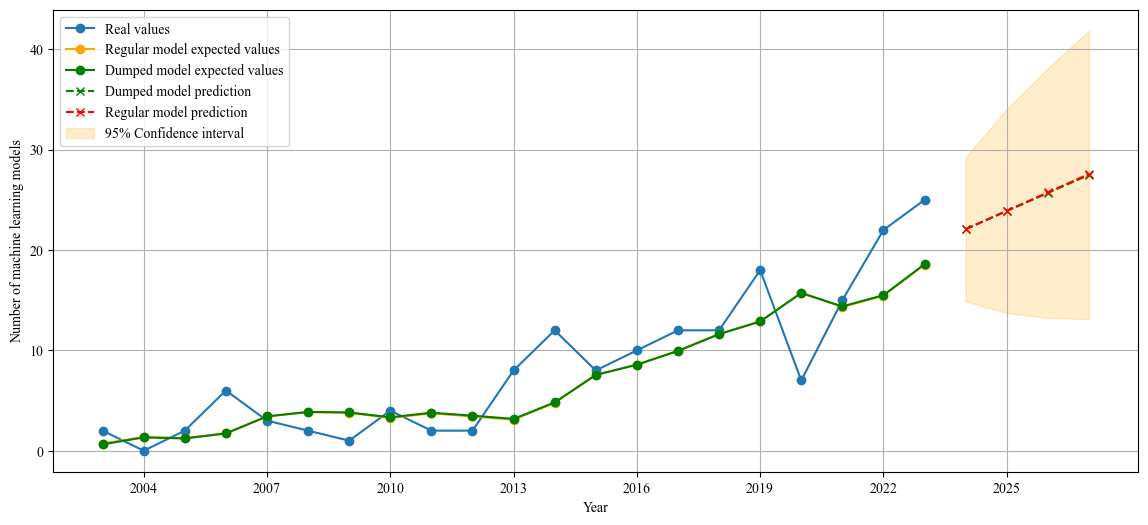

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(df['year'], df['ml_models'], label='Real values', marker='o')
plt.plot(fitted_holt_damped, label='Regular model expected values', marker='o', color='orange')
plt.plot(fitted_holt, label='Dumped model expected values', marker='o', color='green')
plt.plot(forecast_index, holt_damped_forecast2, label='Dumped model prediction', color='green', linestyle='--', marker='x')
plt.plot(forecast_index, holt_forecast2, label='Regular model prediction', color='red', linestyle='--', marker='x')
plt.fill_between(forecast_index, lower_bound, upper_bound, label='95% Confidence interval', color='orange', alpha=0.2)
plt.xlabel('Year')
plt.ylabel("Number of machine learning models")
plt.xticks(xticks_filtered)
plt.legend()
plt.grid(True)

Both models indicate a stable, linear upward trend in the number of significant machine learning models in the European Union. The expected values and predictions of both models are almost identical. The dynamic growth in the number of important machine learning models in 2020-2023 did not affect the rapid increase in prediction values. Due to the very similar results of both models, the next steps, including the assessment of the quality of fit to the data and the properties of the residuals, were performed only for the simpler Holt model without damping. Results were compared to the prediction made with ARIMA.

In [52]:
mse_hw = mean_squared_error(df2['ml_models'], fitted_holt)
rmse_hw = np.sqrt(mse_ar)
mae_hw = mean_absolute_error(df2['ml_models'], fitted_holt)
rsquare_hw = r2_score(df2['ml_models'], fitted_holt)
mape_hw = np.mean(np.abs((df2['ml_models'] - fitted_holt)) / df2['ml_models'])* 100

In [53]:
results = pd.DataFrame({
    'Model': ['Holt', 'AR'],
    'MSE': [mse_hw, mse_ar],
    'RMSE': [rmse_hw, rmse_ar],
    'MAE': [mae_hw, mae_ar],
    'R²': [rsquare_hw, rsquare_ar]
})

results = results.apply(pd.to_numeric, errors='ignore').round(3)

display(results.style.format({
    "MSE": "{:.3f}",
    "RMSE": "{:.3f}",
    "MAE": "{:.3f}",
    "R²": "{:.3f}"
})
 .hide(axis="index")   
)


Model,MSE,RMSE,MAE,R²
Holt,14.635,3.793,2.880,0.700
AR,14.389,3.793,3.041,0.705


Holt's model yielded similar error values to the ARIMA model. The values estimated by both models are also similar over the period under consideration. The coefficient of determination for both models indicates an average degree of explaining the variance of the series, although the series contains outliers that compromise the reliability of this measure.

In [54]:
actual_values = df2['ml_models'].values

In [55]:
residuals = actual_values - fitted_holt

In [56]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Test Shapiro–Wilka: statystyka = 0.9388, p-value = 0.2063


In [57]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.7678


The model residuals exhibit properties that indicate a good fit of the model to the data. According to the p values, the residuals are not heteroscedastic and are normally distributed.

Text(0.5, 1.0, 'Histogram of Residuals')

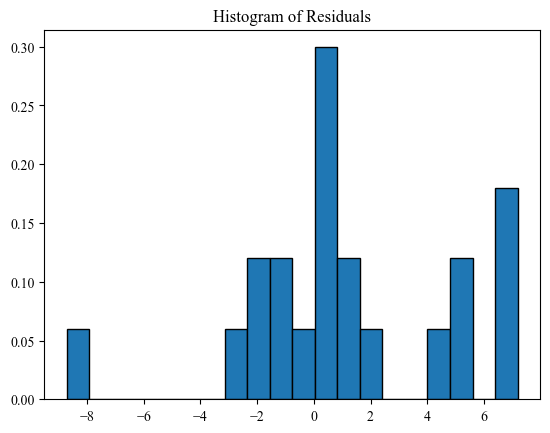

In [58]:
plt.hist(residuals, bins=20, edgecolor="black", density=True)
plt.title("Histogram of Residuals")

### Summary for UE prediction

For the EU and the UK, no model providing a very good fit to the data could be identified. Therefore, the predictions should be treated with caution, considering the general direction of the future number of relevant machine learning models. As with the other series, the forecasting difficulties stemmed primarily from the limited number of observations and the significant, irregular variability of the data over the period under consideration.